In [1]:
import pickle
import torch
from torch import nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import random

In [2]:
# Taken from https://pytorch.org/tutorials/beginner/nn_tutorial.html
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "http://deeplearning.net/data/mnist/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

In [3]:
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        mnist = pickle.load(f, encoding="latin-1")

In [4]:
(training, validation, test) = mnist

In [5]:
x_train, y_train = torch.tensor(training[0]), torch.tensor(training[1])
x_val, y_val = torch.tensor(validation[0]), torch.tensor(validation[1])
x_test, y_test = torch.tensor(test[0]), torch.tensor(test[1])

In [6]:
print(x_train.shape)
x_train[0].view(-1, 1, 28, 28).shape 

torch.Size([50000, 784])


torch.Size([1, 1, 28, 28])

In [7]:
lr = 0.01
epochs = 100
bs = 64
n = len(x_train)

In [8]:
def image(a, dim=(28, 28)):
    img = np.reshape(a, dim)
    imgplot = plt.imshow(img, cmap = "gray")
    plt.show()

In [9]:
loss_func = F.cross_entropy

In [10]:
dev = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")

# dev = torch.device("cuda")
# dev = torch.device("cpu")

dev

device(type='cuda')

In [11]:
def accuracy(out, label):
    match = out.argmax(dim=1) == label
    a = match.float().mean()
    return a

In [12]:
class Mnist_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Conv2d(1, 8, 3, 1, 1)
        self.l2 = nn.AvgPool2d(2, 2)
        self.l3 = nn.Conv2d(8, 13, 3, 1, 1)
        self.l4 = nn.Linear(14*14*13, 10)
        
    def forward(self, d):
        d = d.view(-1, 1, 28, 28)
        d = self.l1(d)
        d = F.relu(d)
        # Store the output of convolutions
        c1 = d
        d = self.l2(d)
        d = self.l3(d)
        d = F.relu(d)
        # Store the output of convolutions
        c2 = d
        d = d.view(-1, 14*14*13)
        d = self.l4(d)
        return (d, c1, c2)

In [13]:
model_dev = Mnist_CNN().to(dev)
x_test_dev = x_test.to(dev)
y_test_dev = y_test.to(dev)

x_val_dev = x_val.to(dev)
y_val_dev = y_val.to(dev)

x_train_dev = x_train.to(dev)
y_train_dev = y_train.to(dev)

x = np.linspace(0, epochs + 1, epochs + 1)
test_y_dev = torch.zeros(epochs + 1, device=dev)
val_y_dev = torch.zeros(epochs + 1, device=dev)
train_y_dev = torch.zeros(epochs + 1, device=dev)

train_y_dev[0] = accuracy(model_dev(x_train_dev)[0], y_train_dev)

In [14]:
def fit4():
    test_y_dev[0] = accuracy(model_dev(x_test_dev)[0], y_test_dev)
    val_y_dev[0] = accuracy(model_dev(x_val_dev)[0], y_val_dev)
    train_y_dev[0] = accuracy(model_dev(x_train_dev)[0], y_train_dev)
    for e in range(epochs):
        for i in range(int((n - 1)/bs) + 1):
            start = bs * i
            end = bs * (i + 1)
            xb = x_train[start:end].to(dev)
            yb = y_train[start:end].to(dev)
            pred = model_dev(xb)[0]
            loss = loss_func(pred, yb)
            loss.backward()
        
            with torch.no_grad():
                for p in model_dev.parameters():
                    p -= p.grad * lr
                model_dev.zero_grad()
        with torch.no_grad():
            test_y_dev[e + 1] = accuracy(model_dev(x_test_dev)[0], y_test_dev)
            val_y_dev[e + 1] = accuracy(model_dev(x_val_dev)[0], y_val_dev)
            train_y_dev[e + 1] = accuracy(model_dev(x_train_dev)[0], y_train_dev)
        
    plt.plot(x, test_y_dev.cpu().numpy(), label='test')
    plt.plot(x, val_y_dev.cpu().numpy(), label='val')
    plt.plot(x, train_y_dev.cpu().numpy(), label='train')
    plt.xlabel('epochs')
    plt.ylabel('acc')
    plt.title("Simple Plot")
    plt.legend()
    plt.show()

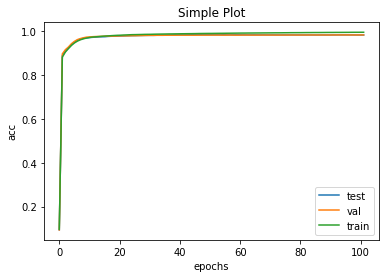

In [15]:
fit4()

In [16]:
print(f'Final acc test {test_y_dev[epochs]}')
print(f'Final acc val {val_y_dev[epochs]}')
print(f'Final acc train {train_y_dev[epochs]}')

Final acc test 0.9819999933242798
Final acc val 0.9822999835014343
Final acc train 0.9946399927139282


In [17]:
# Plot all the images where label and prediction are different
def plot_err(dx, dy):
    out = model_dev(dx)[0]
    o = out.argmax(dim=1)
    match = o == dy
    # print(match, o.shape, out.shape, dy.shape, dx.shape)
    j = 0
    for i in match:
        if i == 0:
            image(dx[j].cpu())
            print("Label: ", dy[j], "Prediction: ", o[j])
        j = j + 1

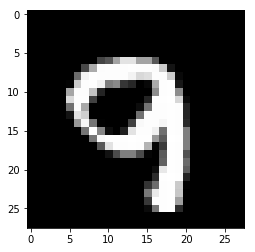

Label:  tensor(9, device='cuda:0') Prediction:  tensor(3, device='cuda:0')


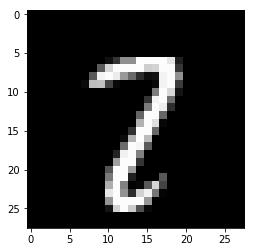

Label:  tensor(2, device='cuda:0') Prediction:  tensor(7, device='cuda:0')


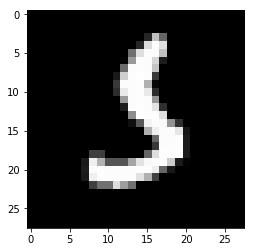

Label:  tensor(5, device='cuda:0') Prediction:  tensor(3, device='cuda:0')


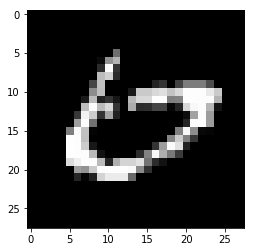

Label:  tensor(6, device='cuda:0') Prediction:  tensor(0, device='cuda:0')


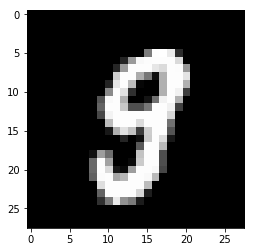

Label:  tensor(9, device='cuda:0') Prediction:  tensor(8, device='cuda:0')


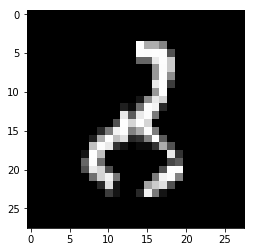

Label:  tensor(8, device='cuda:0') Prediction:  tensor(2, device='cuda:0')


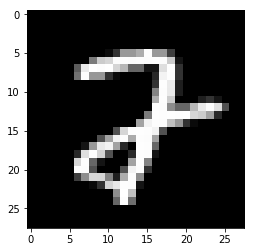

Label:  tensor(2, device='cuda:0') Prediction:  tensor(7, device='cuda:0')


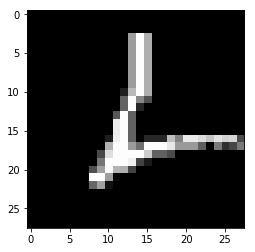

Label:  tensor(2, device='cuda:0') Prediction:  tensor(6, device='cuda:0')


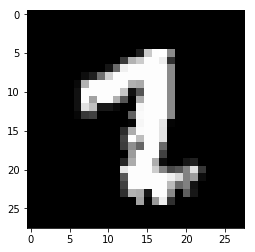

Label:  tensor(2, device='cuda:0') Prediction:  tensor(1, device='cuda:0')


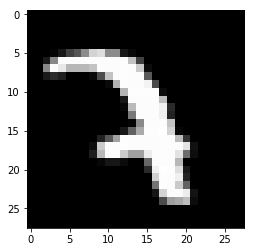

Label:  tensor(7, device='cuda:0') Prediction:  tensor(3, device='cuda:0')


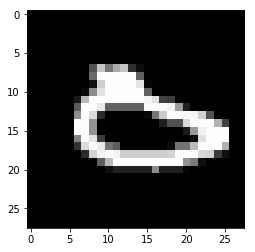

Label:  tensor(0, device='cuda:0') Prediction:  tensor(3, device='cuda:0')


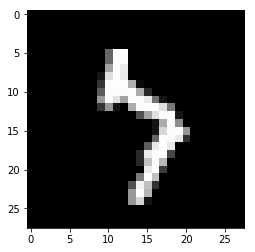

Label:  tensor(7, device='cuda:0') Prediction:  tensor(9, device='cuda:0')


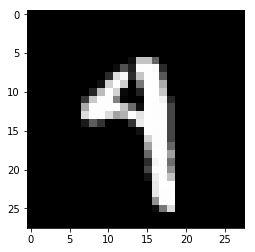

Label:  tensor(4, device='cuda:0') Prediction:  tensor(9, device='cuda:0')


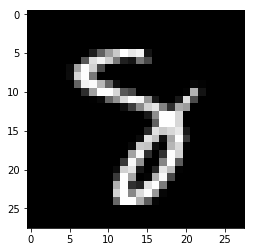

Label:  tensor(8, device='cuda:0') Prediction:  tensor(7, device='cuda:0')


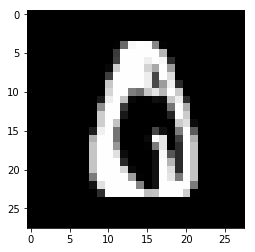

Label:  tensor(0, device='cuda:0') Prediction:  tensor(6, device='cuda:0')


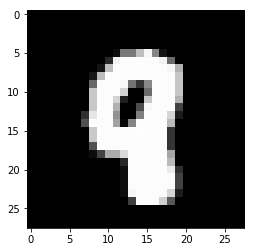

Label:  tensor(8, device='cuda:0') Prediction:  tensor(9, device='cuda:0')


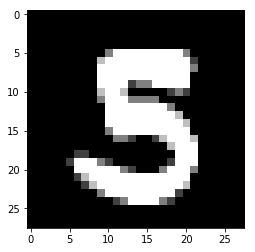

Label:  tensor(5, device='cuda:0') Prediction:  tensor(3, device='cuda:0')


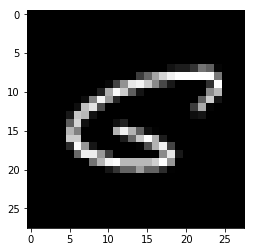

Label:  tensor(6, device='cuda:0') Prediction:  tensor(5, device='cuda:0')


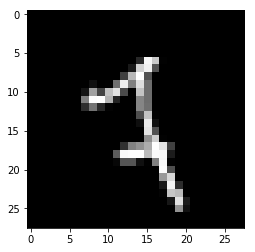

Label:  tensor(7, device='cuda:0') Prediction:  tensor(2, device='cuda:0')


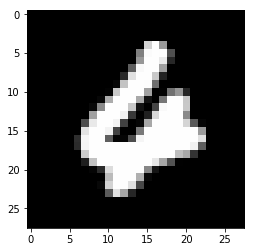

Label:  tensor(4, device='cuda:0') Prediction:  tensor(6, device='cuda:0')


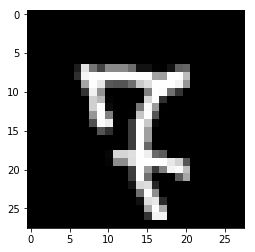

Label:  tensor(7, device='cuda:0') Prediction:  tensor(8, device='cuda:0')


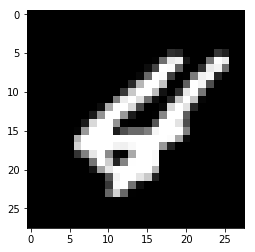

Label:  tensor(4, device='cuda:0') Prediction:  tensor(0, device='cuda:0')


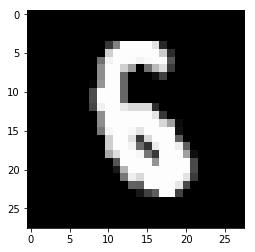

Label:  tensor(6, device='cuda:0') Prediction:  tensor(5, device='cuda:0')


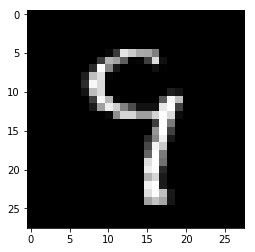

Label:  tensor(9, device='cuda:0') Prediction:  tensor(7, device='cuda:0')


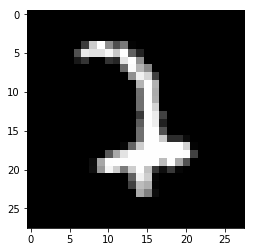

Label:  tensor(7, device='cuda:0') Prediction:  tensor(2, device='cuda:0')


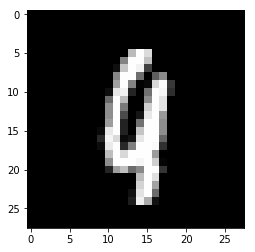

Label:  tensor(9, device='cuda:0') Prediction:  tensor(4, device='cuda:0')


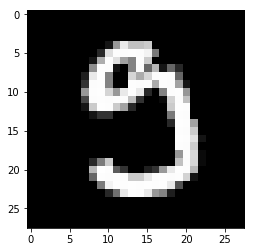

Label:  tensor(9, device='cuda:0') Prediction:  tensor(5, device='cuda:0')


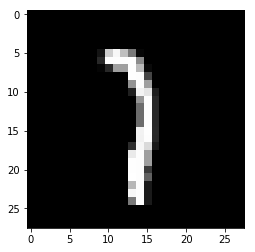

Label:  tensor(7, device='cuda:0') Prediction:  tensor(1, device='cuda:0')


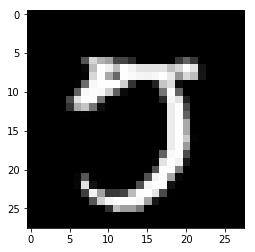

Label:  tensor(5, device='cuda:0') Prediction:  tensor(7, device='cuda:0')


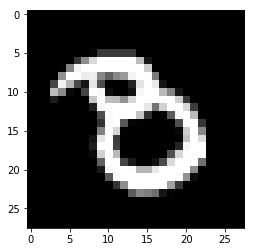

Label:  tensor(8, device='cuda:0') Prediction:  tensor(0, device='cuda:0')


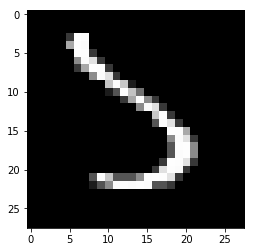

Label:  tensor(5, device='cuda:0') Prediction:  tensor(3, device='cuda:0')


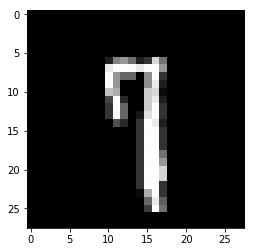

Label:  tensor(7, device='cuda:0') Prediction:  tensor(9, device='cuda:0')


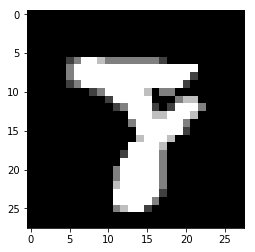

Label:  tensor(8, device='cuda:0') Prediction:  tensor(7, device='cuda:0')


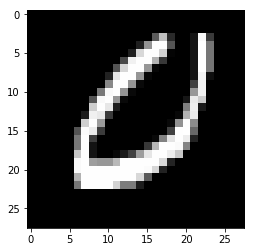

Label:  tensor(0, device='cuda:0') Prediction:  tensor(4, device='cuda:0')


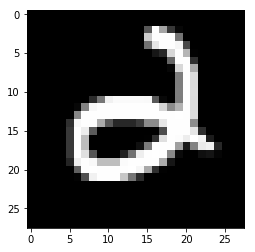

Label:  tensor(2, device='cuda:0') Prediction:  tensor(3, device='cuda:0')


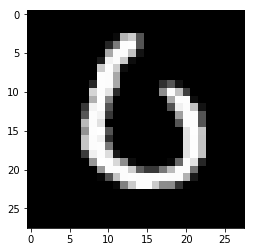

Label:  tensor(0, device='cuda:0') Prediction:  tensor(6, device='cuda:0')


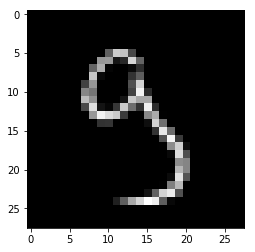

Label:  tensor(9, device='cuda:0') Prediction:  tensor(5, device='cuda:0')


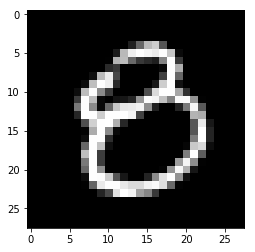

Label:  tensor(8, device='cuda:0') Prediction:  tensor(0, device='cuda:0')


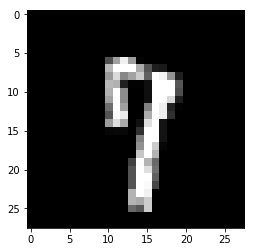

Label:  tensor(7, device='cuda:0') Prediction:  tensor(9, device='cuda:0')


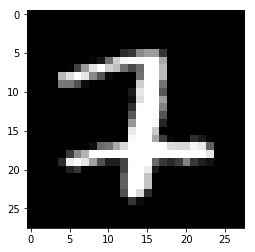

Label:  tensor(7, device='cuda:0') Prediction:  tensor(2, device='cuda:0')


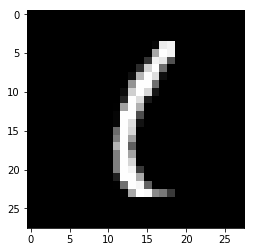

Label:  tensor(1, device='cuda:0') Prediction:  tensor(6, device='cuda:0')


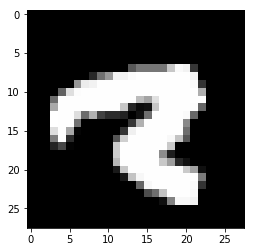

Label:  tensor(2, device='cuda:0') Prediction:  tensor(7, device='cuda:0')


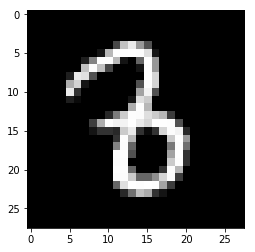

Label:  tensor(8, device='cuda:0') Prediction:  tensor(3, device='cuda:0')


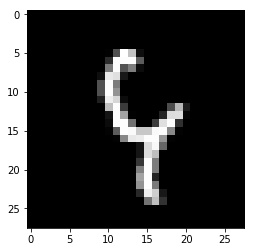

Label:  tensor(9, device='cuda:0') Prediction:  tensor(4, device='cuda:0')


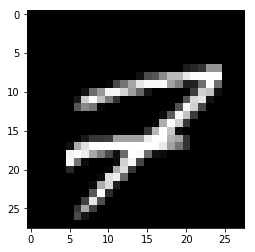

Label:  tensor(7, device='cuda:0') Prediction:  tensor(2, device='cuda:0')


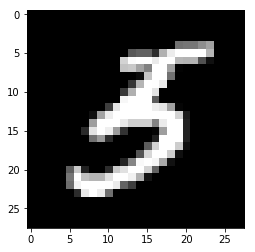

Label:  tensor(5, device='cuda:0') Prediction:  tensor(3, device='cuda:0')


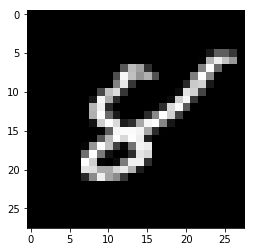

Label:  tensor(8, device='cuda:0') Prediction:  tensor(4, device='cuda:0')


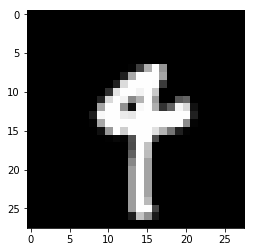

Label:  tensor(4, device='cuda:0') Prediction:  tensor(9, device='cuda:0')


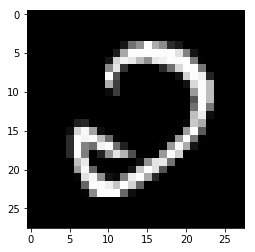

Label:  tensor(2, device='cuda:0') Prediction:  tensor(0, device='cuda:0')


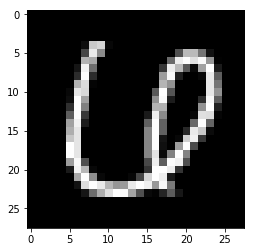

Label:  tensor(6, device='cuda:0') Prediction:  tensor(0, device='cuda:0')


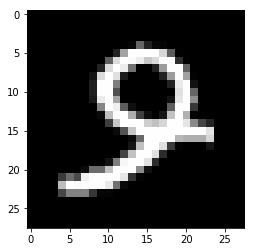

Label:  tensor(9, device='cuda:0') Prediction:  tensor(2, device='cuda:0')


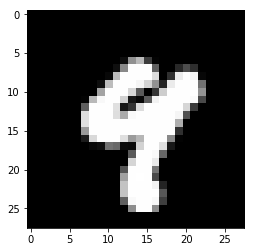

Label:  tensor(4, device='cuda:0') Prediction:  tensor(9, device='cuda:0')


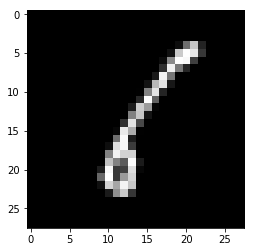

Label:  tensor(6, device='cuda:0') Prediction:  tensor(8, device='cuda:0')


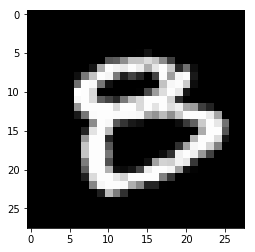

Label:  tensor(8, device='cuda:0') Prediction:  tensor(0, device='cuda:0')


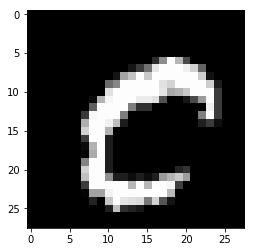

Label:  tensor(0, device='cuda:0') Prediction:  tensor(8, device='cuda:0')


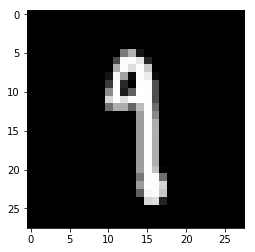

Label:  tensor(9, device='cuda:0') Prediction:  tensor(1, device='cuda:0')


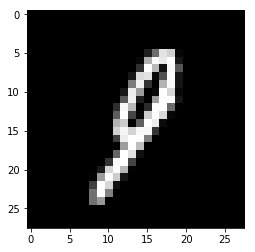

Label:  tensor(9, device='cuda:0') Prediction:  tensor(8, device='cuda:0')


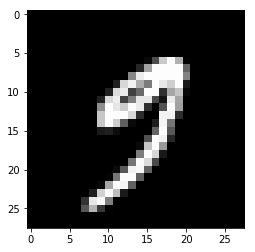

Label:  tensor(9, device='cuda:0') Prediction:  tensor(5, device='cuda:0')


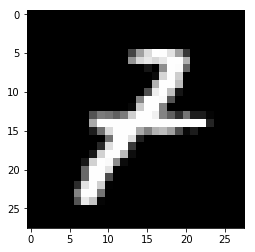

Label:  tensor(7, device='cuda:0') Prediction:  tensor(2, device='cuda:0')


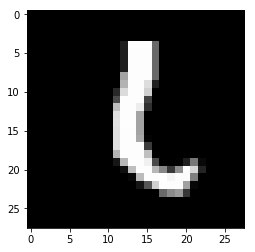

Label:  tensor(6, device='cuda:0') Prediction:  tensor(1, device='cuda:0')


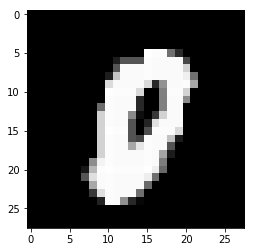

Label:  tensor(0, device='cuda:0') Prediction:  tensor(8, device='cuda:0')


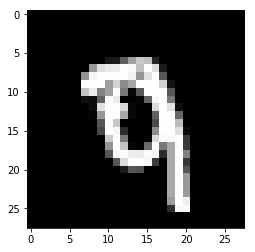

Label:  tensor(9, device='cuda:0') Prediction:  tensor(7, device='cuda:0')


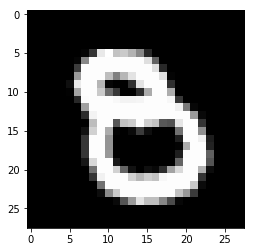

Label:  tensor(8, device='cuda:0') Prediction:  tensor(5, device='cuda:0')


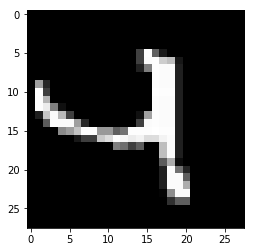

Label:  tensor(4, device='cuda:0') Prediction:  tensor(3, device='cuda:0')


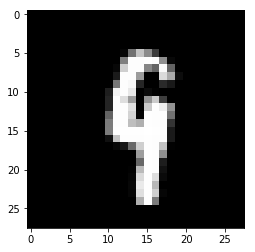

Label:  tensor(9, device='cuda:0') Prediction:  tensor(4, device='cuda:0')


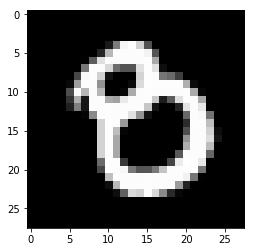

Label:  tensor(8, device='cuda:0') Prediction:  tensor(0, device='cuda:0')


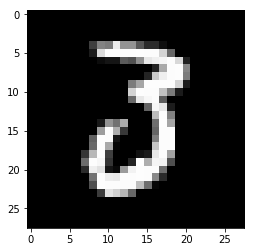

Label:  tensor(3, device='cuda:0') Prediction:  tensor(2, device='cuda:0')


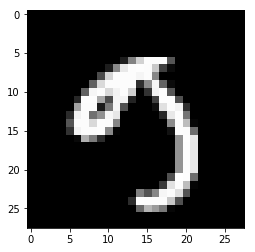

Label:  tensor(9, device='cuda:0') Prediction:  tensor(5, device='cuda:0')


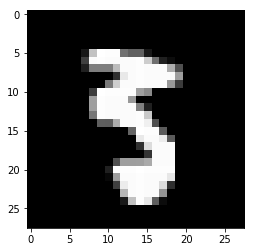

Label:  tensor(3, device='cuda:0') Prediction:  tensor(5, device='cuda:0')


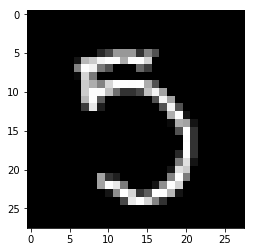

Label:  tensor(5, device='cuda:0') Prediction:  tensor(3, device='cuda:0')


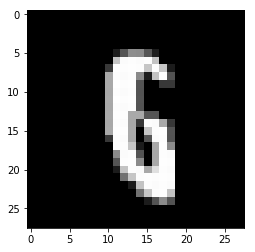

Label:  tensor(6, device='cuda:0') Prediction:  tensor(8, device='cuda:0')


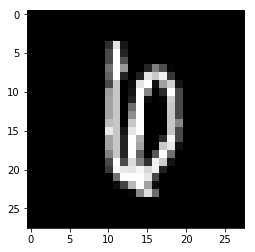

Label:  tensor(6, device='cuda:0') Prediction:  tensor(0, device='cuda:0')


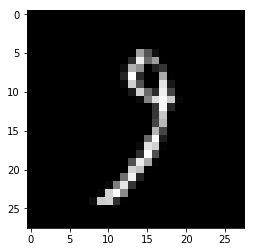

Label:  tensor(9, device='cuda:0') Prediction:  tensor(2, device='cuda:0')


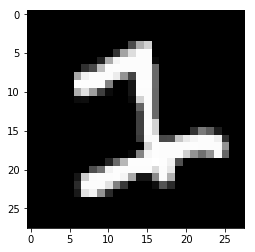

Label:  tensor(1, device='cuda:0') Prediction:  tensor(2, device='cuda:0')


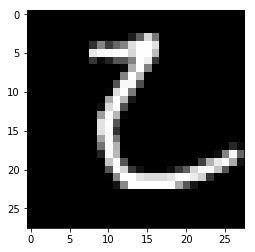

Label:  tensor(2, device='cuda:0') Prediction:  tensor(1, device='cuda:0')


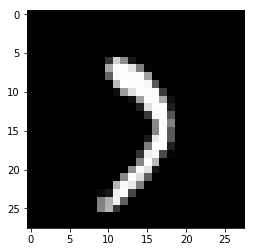

Label:  tensor(7, device='cuda:0') Prediction:  tensor(9, device='cuda:0')


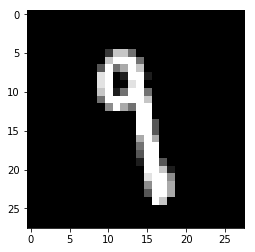

Label:  tensor(9, device='cuda:0') Prediction:  tensor(1, device='cuda:0')


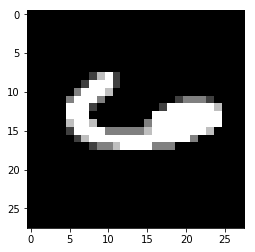

Label:  tensor(6, device='cuda:0') Prediction:  tensor(4, device='cuda:0')


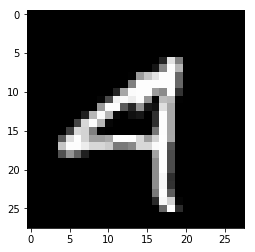

Label:  tensor(4, device='cuda:0') Prediction:  tensor(5, device='cuda:0')


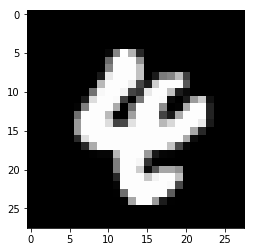

Label:  tensor(4, device='cuda:0') Prediction:  tensor(8, device='cuda:0')


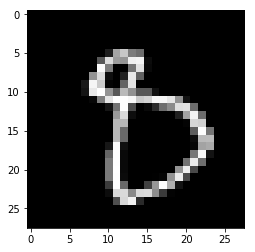

Label:  tensor(8, device='cuda:0') Prediction:  tensor(5, device='cuda:0')


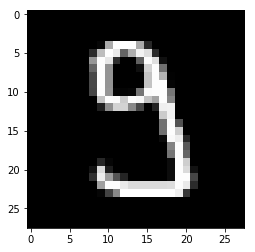

Label:  tensor(9, device='cuda:0') Prediction:  tensor(3, device='cuda:0')


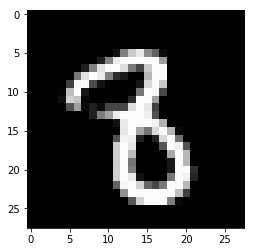

Label:  tensor(8, device='cuda:0') Prediction:  tensor(3, device='cuda:0')


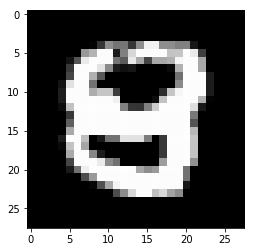

Label:  tensor(8, device='cuda:0') Prediction:  tensor(9, device='cuda:0')


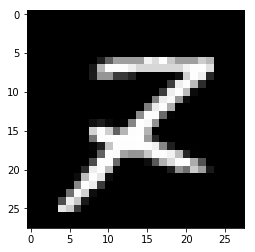

Label:  tensor(7, device='cuda:0') Prediction:  tensor(2, device='cuda:0')


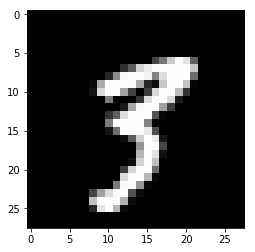

Label:  tensor(3, device='cuda:0') Prediction:  tensor(9, device='cuda:0')


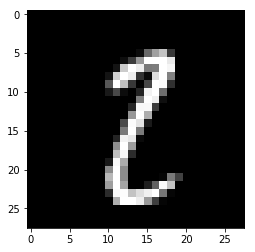

Label:  tensor(2, device='cuda:0') Prediction:  tensor(8, device='cuda:0')


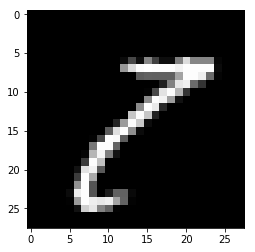

Label:  tensor(7, device='cuda:0') Prediction:  tensor(8, device='cuda:0')


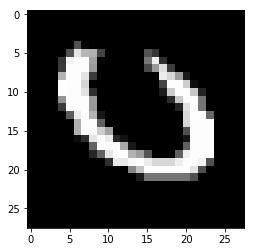

Label:  tensor(0, device='cuda:0') Prediction:  tensor(4, device='cuda:0')


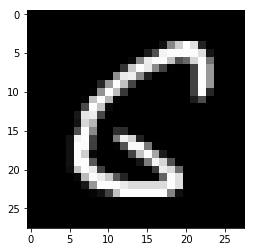

Label:  tensor(6, device='cuda:0') Prediction:  tensor(8, device='cuda:0')


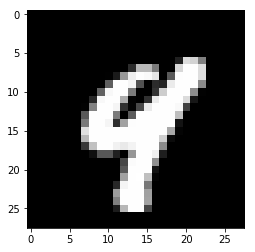

Label:  tensor(9, device='cuda:0') Prediction:  tensor(4, device='cuda:0')


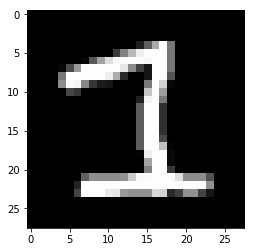

Label:  tensor(1, device='cuda:0') Prediction:  tensor(3, device='cuda:0')


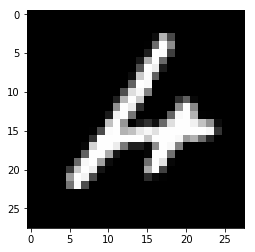

Label:  tensor(4, device='cuda:0') Prediction:  tensor(2, device='cuda:0')


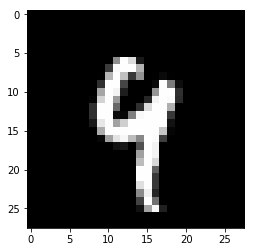

Label:  tensor(9, device='cuda:0') Prediction:  tensor(4, device='cuda:0')


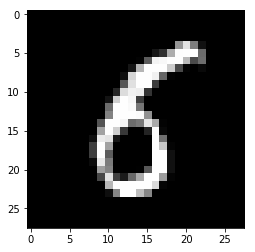

Label:  tensor(6, device='cuda:0') Prediction:  tensor(5, device='cuda:0')


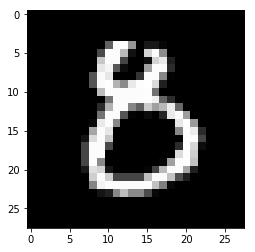

Label:  tensor(8, device='cuda:0') Prediction:  tensor(0, device='cuda:0')


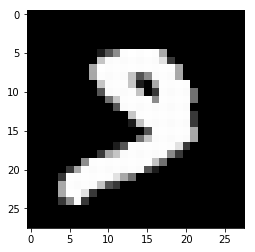

Label:  tensor(9, device='cuda:0') Prediction:  tensor(3, device='cuda:0')


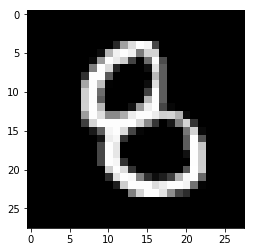

Label:  tensor(8, device='cuda:0') Prediction:  tensor(6, device='cuda:0')


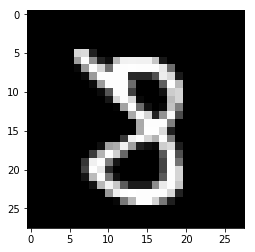

Label:  tensor(8, device='cuda:0') Prediction:  tensor(3, device='cuda:0')


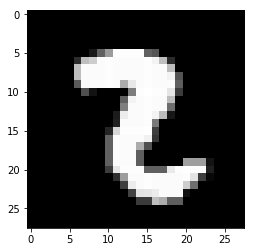

Label:  tensor(2, device='cuda:0') Prediction:  tensor(3, device='cuda:0')


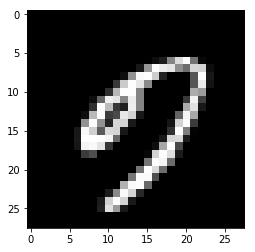

Label:  tensor(9, device='cuda:0') Prediction:  tensor(2, device='cuda:0')


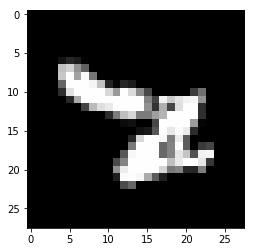

Label:  tensor(2, device='cuda:0') Prediction:  tensor(7, device='cuda:0')


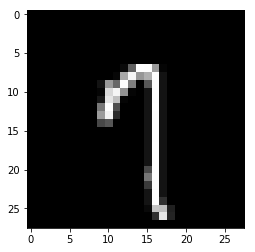

Label:  tensor(7, device='cuda:0') Prediction:  tensor(9, device='cuda:0')


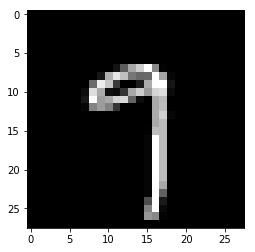

Label:  tensor(9, device='cuda:0') Prediction:  tensor(7, device='cuda:0')


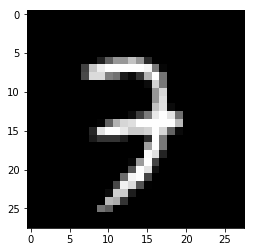

Label:  tensor(7, device='cuda:0') Prediction:  tensor(3, device='cuda:0')


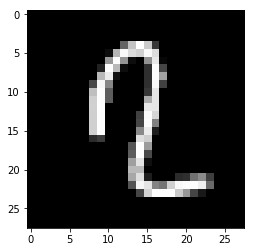

Label:  tensor(2, device='cuda:0') Prediction:  tensor(8, device='cuda:0')


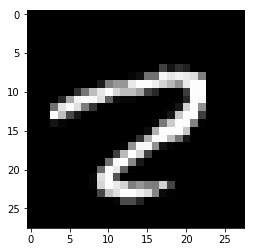

Label:  tensor(2, device='cuda:0') Prediction:  tensor(8, device='cuda:0')


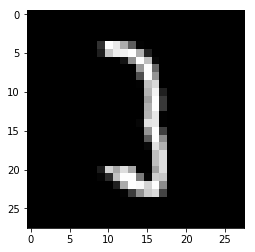

Label:  tensor(3, device='cuda:0') Prediction:  tensor(2, device='cuda:0')


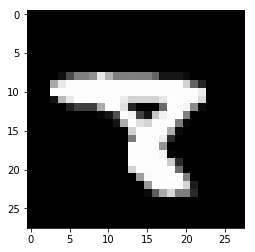

Label:  tensor(8, device='cuda:0') Prediction:  tensor(7, device='cuda:0')


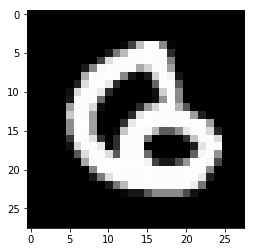

Label:  tensor(6, device='cuda:0') Prediction:  tensor(3, device='cuda:0')


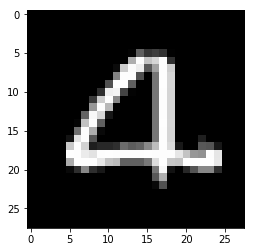

Label:  tensor(4, device='cuda:0') Prediction:  tensor(2, device='cuda:0')


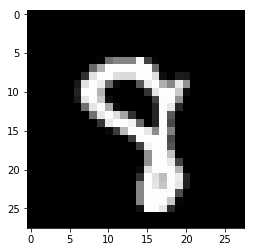

Label:  tensor(8, device='cuda:0') Prediction:  tensor(9, device='cuda:0')


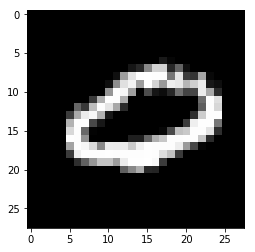

Label:  tensor(0, device='cuda:0') Prediction:  tensor(9, device='cuda:0')


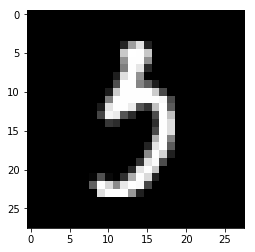

Label:  tensor(3, device='cuda:0') Prediction:  tensor(5, device='cuda:0')


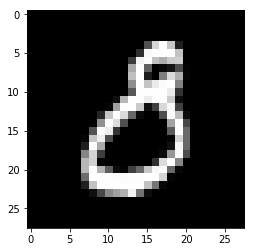

Label:  tensor(8, device='cuda:0') Prediction:  tensor(5, device='cuda:0')


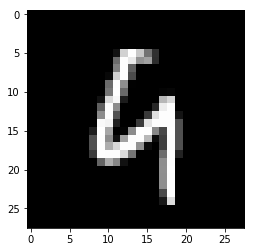

Label:  tensor(9, device='cuda:0') Prediction:  tensor(4, device='cuda:0')


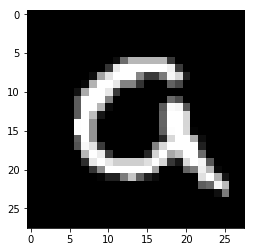

Label:  tensor(9, device='cuda:0') Prediction:  tensor(2, device='cuda:0')


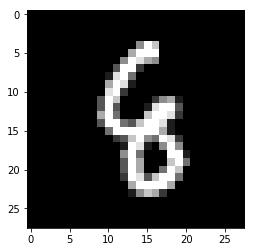

Label:  tensor(8, device='cuda:0') Prediction:  tensor(6, device='cuda:0')


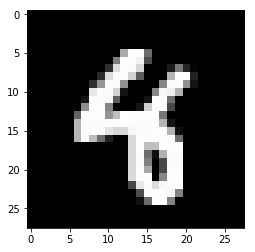

Label:  tensor(8, device='cuda:0') Prediction:  tensor(4, device='cuda:0')


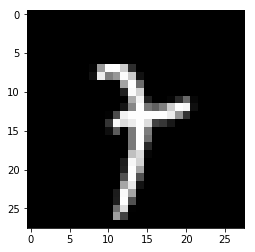

Label:  tensor(7, device='cuda:0') Prediction:  tensor(3, device='cuda:0')


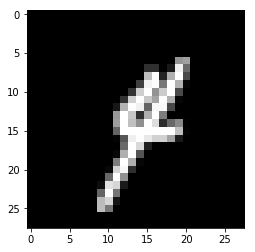

Label:  tensor(4, device='cuda:0') Prediction:  tensor(7, device='cuda:0')


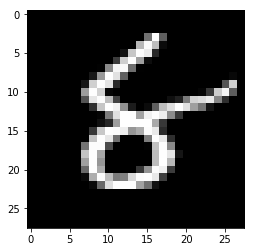

Label:  tensor(8, device='cuda:0') Prediction:  tensor(5, device='cuda:0')


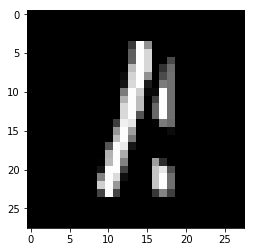

Label:  tensor(1, device='cuda:0') Prediction:  tensor(8, device='cuda:0')


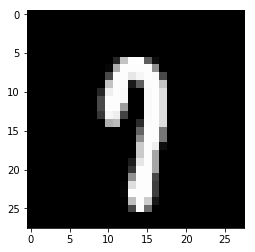

Label:  tensor(7, device='cuda:0') Prediction:  tensor(9, device='cuda:0')


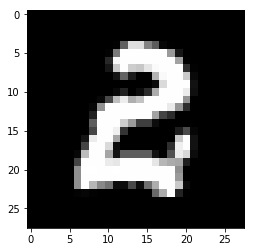

Label:  tensor(2, device='cuda:0') Prediction:  tensor(3, device='cuda:0')


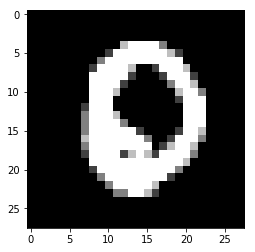

Label:  tensor(0, device='cuda:0') Prediction:  tensor(6, device='cuda:0')


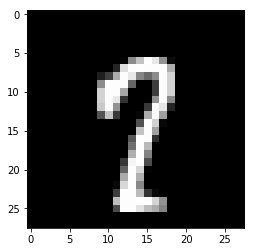

Label:  tensor(7, device='cuda:0') Prediction:  tensor(2, device='cuda:0')


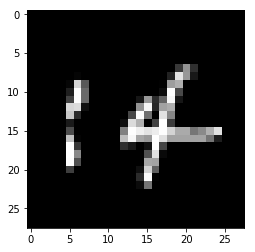

Label:  tensor(4, device='cuda:0') Prediction:  tensor(6, device='cuda:0')


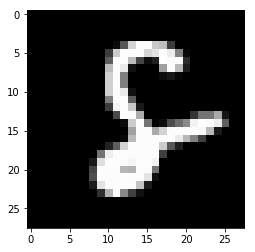

Label:  tensor(8, device='cuda:0') Prediction:  tensor(2, device='cuda:0')


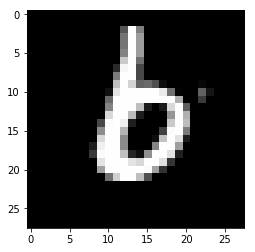

Label:  tensor(6, device='cuda:0') Prediction:  tensor(0, device='cuda:0')


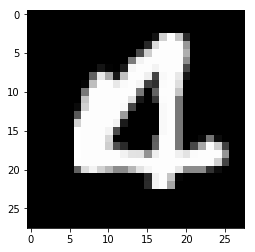

Label:  tensor(4, device='cuda:0') Prediction:  tensor(0, device='cuda:0')


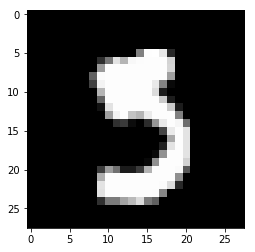

Label:  tensor(5, device='cuda:0') Prediction:  tensor(3, device='cuda:0')


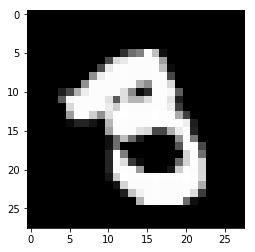

Label:  tensor(3, device='cuda:0') Prediction:  tensor(8, device='cuda:0')


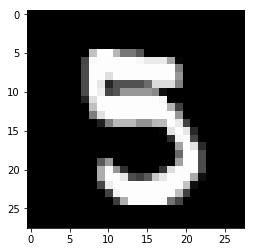

Label:  tensor(5, device='cuda:0') Prediction:  tensor(3, device='cuda:0')


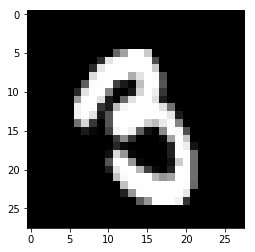

Label:  tensor(3, device='cuda:0') Prediction:  tensor(8, device='cuda:0')


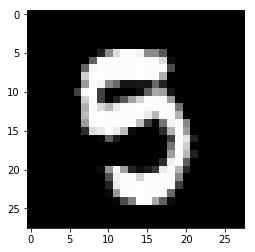

Label:  tensor(5, device='cuda:0') Prediction:  tensor(9, device='cuda:0')


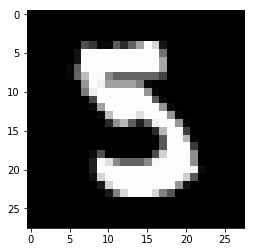

Label:  tensor(5, device='cuda:0') Prediction:  tensor(3, device='cuda:0')


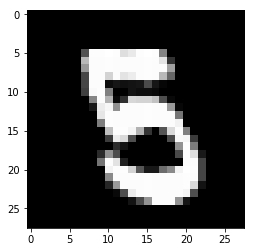

Label:  tensor(5, device='cuda:0') Prediction:  tensor(3, device='cuda:0')


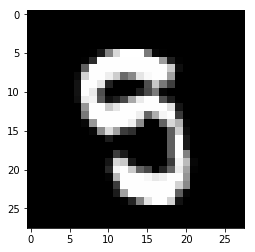

Label:  tensor(5, device='cuda:0') Prediction:  tensor(8, device='cuda:0')


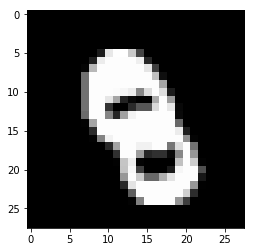

Label:  tensor(8, device='cuda:0') Prediction:  tensor(3, device='cuda:0')


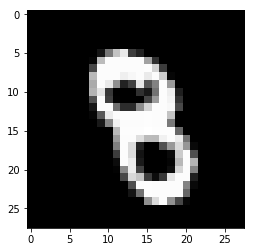

Label:  tensor(8, device='cuda:0') Prediction:  tensor(3, device='cuda:0')


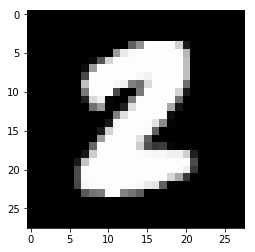

Label:  tensor(2, device='cuda:0') Prediction:  tensor(8, device='cuda:0')


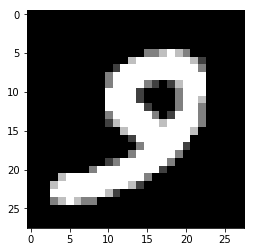

Label:  tensor(9, device='cuda:0') Prediction:  tensor(3, device='cuda:0')


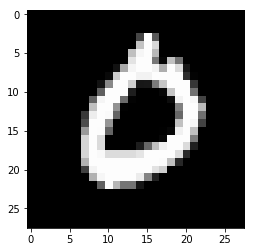

Label:  tensor(0, device='cuda:0') Prediction:  tensor(6, device='cuda:0')


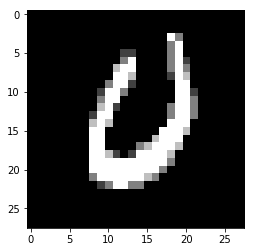

Label:  tensor(0, device='cuda:0') Prediction:  tensor(4, device='cuda:0')


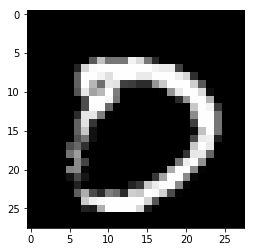

Label:  tensor(0, device='cuda:0') Prediction:  tensor(5, device='cuda:0')


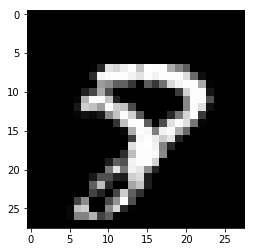

Label:  tensor(8, device='cuda:0') Prediction:  tensor(9, device='cuda:0')


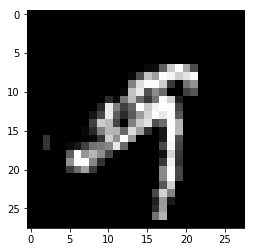

Label:  tensor(9, device='cuda:0') Prediction:  tensor(1, device='cuda:0')


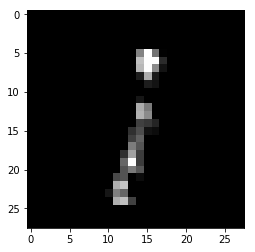

Label:  tensor(1, device='cuda:0') Prediction:  tensor(8, device='cuda:0')


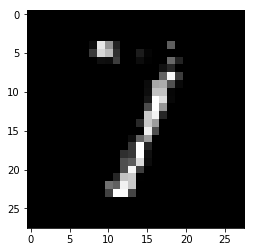

Label:  tensor(7, device='cuda:0') Prediction:  tensor(1, device='cuda:0')


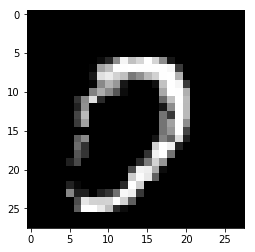

Label:  tensor(0, device='cuda:0') Prediction:  tensor(3, device='cuda:0')


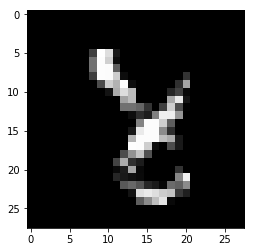

Label:  tensor(8, device='cuda:0') Prediction:  tensor(2, device='cuda:0')


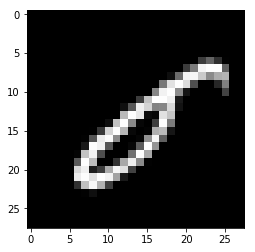

Label:  tensor(0, device='cuda:0') Prediction:  tensor(8, device='cuda:0')


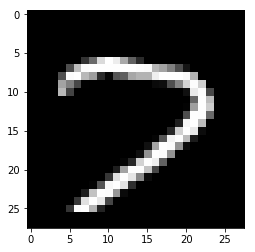

Label:  tensor(7, device='cuda:0') Prediction:  tensor(9, device='cuda:0')


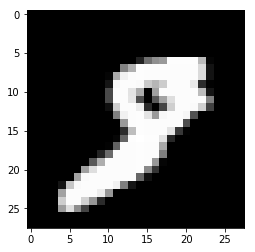

Label:  tensor(8, device='cuda:0') Prediction:  tensor(9, device='cuda:0')


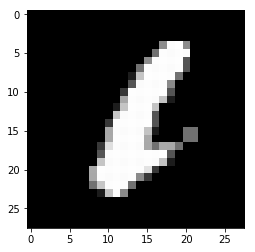

Label:  tensor(1, device='cuda:0') Prediction:  tensor(6, device='cuda:0')


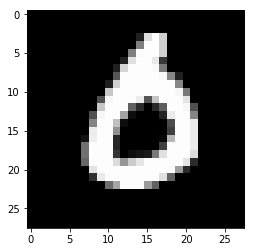

Label:  tensor(0, device='cuda:0') Prediction:  tensor(6, device='cuda:0')


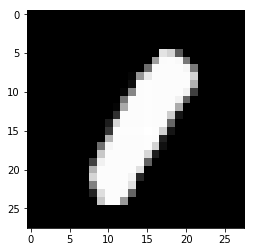

Label:  tensor(1, device='cuda:0') Prediction:  tensor(8, device='cuda:0')


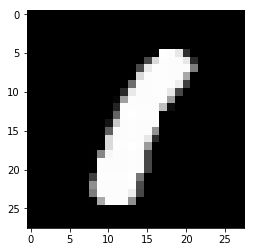

Label:  tensor(1, device='cuda:0') Prediction:  tensor(8, device='cuda:0')


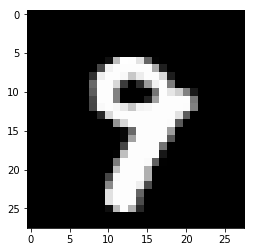

Label:  tensor(9, device='cuda:0') Prediction:  tensor(8, device='cuda:0')


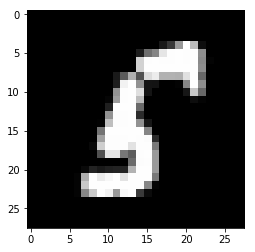

Label:  tensor(5, device='cuda:0') Prediction:  tensor(6, device='cuda:0')


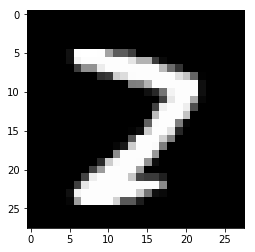

Label:  tensor(7, device='cuda:0') Prediction:  tensor(3, device='cuda:0')


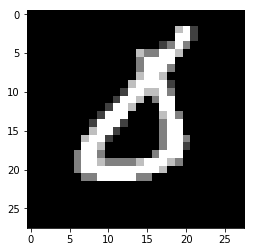

Label:  tensor(0, device='cuda:0') Prediction:  tensor(6, device='cuda:0')


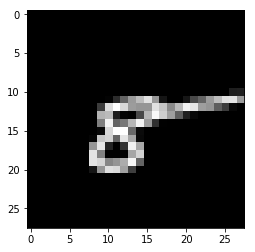

Label:  tensor(8, device='cuda:0') Prediction:  tensor(5, device='cuda:0')


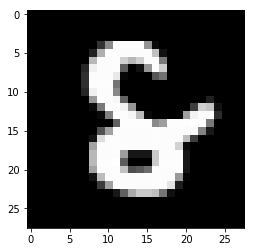

Label:  tensor(8, device='cuda:0') Prediction:  tensor(6, device='cuda:0')


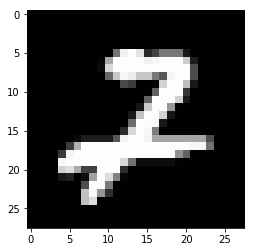

Label:  tensor(7, device='cuda:0') Prediction:  tensor(2, device='cuda:0')


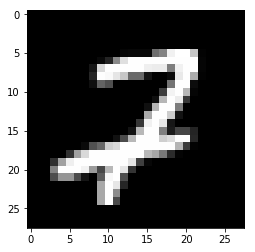

Label:  tensor(7, device='cuda:0') Prediction:  tensor(2, device='cuda:0')


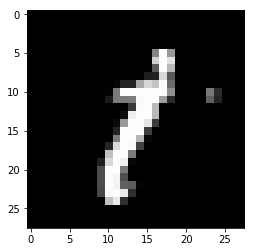

Label:  tensor(1, device='cuda:0') Prediction:  tensor(8, device='cuda:0')


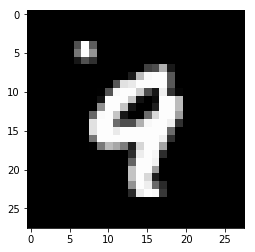

Label:  tensor(9, device='cuda:0') Prediction:  tensor(4, device='cuda:0')


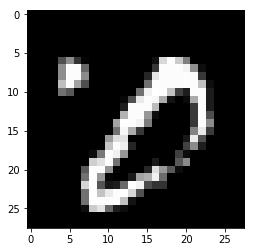

Label:  tensor(0, device='cuda:0') Prediction:  tensor(8, device='cuda:0')


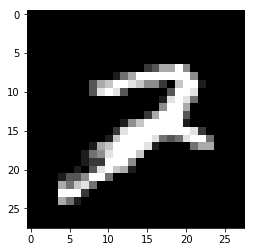

Label:  tensor(2, device='cuda:0') Prediction:  tensor(7, device='cuda:0')


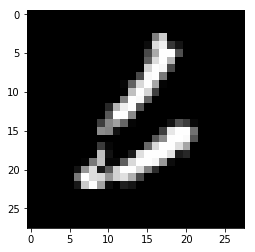

Label:  tensor(6, device='cuda:0') Prediction:  tensor(2, device='cuda:0')


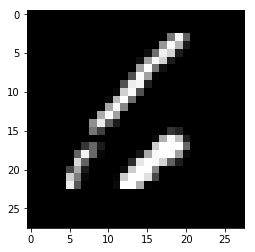

Label:  tensor(6, device='cuda:0') Prediction:  tensor(1, device='cuda:0')


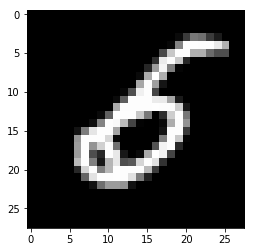

Label:  tensor(5, device='cuda:0') Prediction:  tensor(6, device='cuda:0')


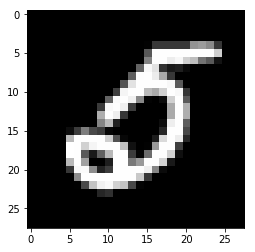

Label:  tensor(5, device='cuda:0') Prediction:  tensor(0, device='cuda:0')


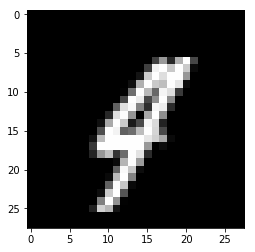

Label:  tensor(4, device='cuda:0') Prediction:  tensor(7, device='cuda:0')


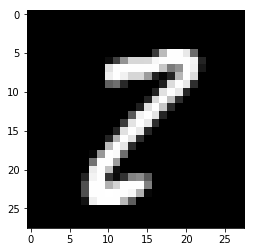

Label:  tensor(2, device='cuda:0') Prediction:  tensor(8, device='cuda:0')


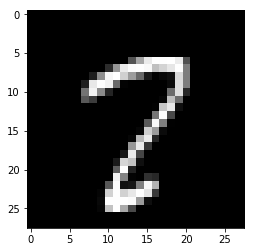

Label:  tensor(2, device='cuda:0') Prediction:  tensor(3, device='cuda:0')


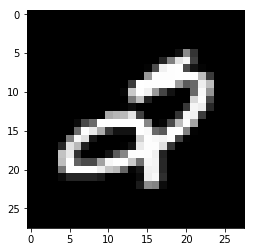

Label:  tensor(2, device='cuda:0') Prediction:  tensor(6, device='cuda:0')


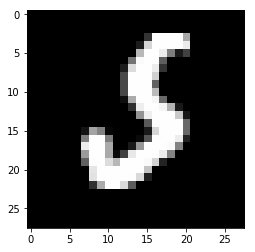

Label:  tensor(5, device='cuda:0') Prediction:  tensor(6, device='cuda:0')


In [18]:
plot_err(x_test_dev, y_test_dev)

In [19]:
(d, c1, c2) = model_dev(x_test_dev[100])
c1.shape, c2.shape

(torch.Size([1, 8, 28, 28]), torch.Size([1, 13, 14, 14]))

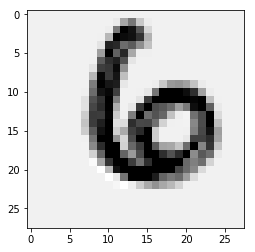

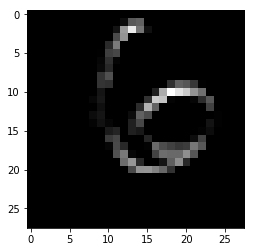

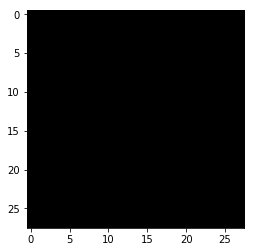

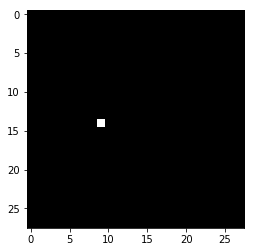

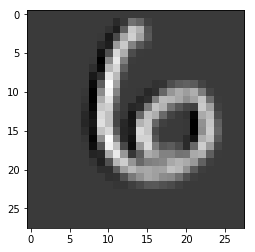

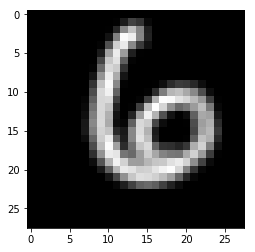

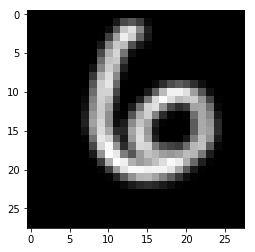

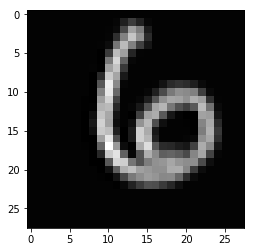

In [20]:
# Plot the output of 1st convolution layer
for i in range(0, 8): image(c1[0][i].view(784).detach().cpu())

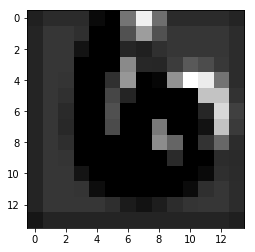

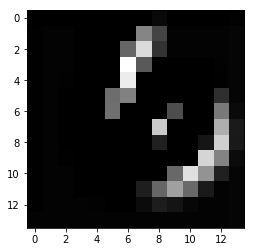

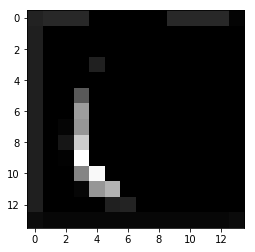

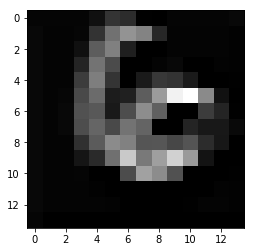

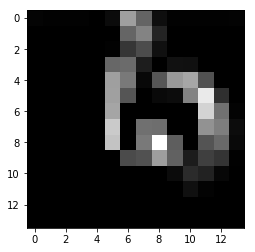

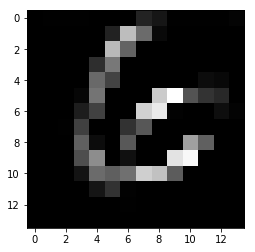

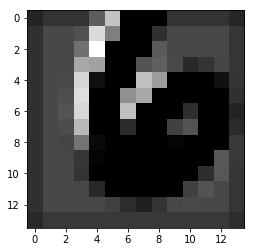

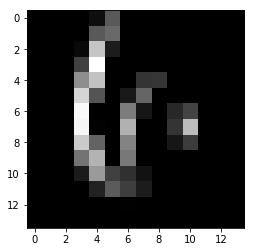

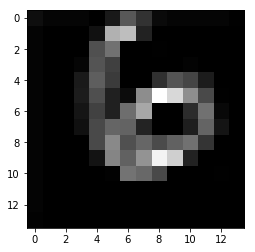

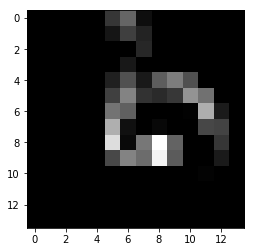

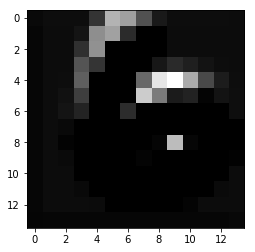

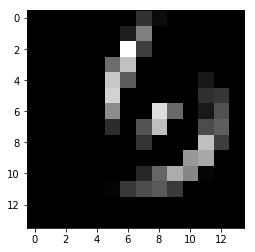

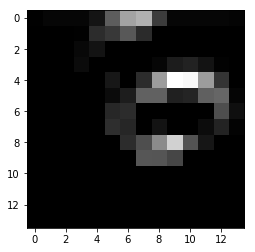

In [21]:
# Plot the output of 2nd convolution layer
for i in range(0, 13): image(c2[0][i].view(196).detach().cpu(), (14, 14))